## Description of VAEs

<img src="VAE_graph.png" alt= “” width="600" height="450">

A VAE is a encoder-decoder network designed to compress input data $X$ to a lower dimensional representation $Z$, called latent representation such that one can reconstruct the original data from $Z$, and generate new data from random samples of $Z$. The VAE consists of an encoder network $Q$ encoding the input information on the latent space in form of functions $\mu(x)$ and $\Sigma(x)$ and a decoder network $f$. In contrast to an autoencoder (AE), a VAE is trained such that for each spectrum we compute a Mean vector $\mu(x)$ and Variance matrix $\Sigma(x)$ to construct a normal distribution in $Z$, best representing the input spectrum $x$ through $\mu(x)$. For the reconstruction a latent variable $z'$ is then sampled from the distribution $Q$ ~ $\mathcal{N}(\mu, \Sigma)$, and the spectrum $x' = f(z')$ is reconstructed by the decoder network $f$. The network is optimized through expectation maximization of the log likelihood $\log P(X \mid z) \propto-\|X-f(z)\|^{2}$, which is the $\mathcal{L}^{2}$-norm on the input spectrum $x$ and the reconstructed spectrum $f(z)$. The full log likelihood is given by
$$
\begin{split}
    L = E_{X \sim D}\left[E_{\epsilon \sim \mathcal{N}(0, I)} \left[ \log P \left(X \mid z = \mu(X) + \Sigma^{1/2} (X) \cdot \epsilon \right) \right] \\
    -\mathcal{D}[Q(z \mid X) \| P(z)] \right],
\end{split}
$$

where , and $\mathcal{D}[Q(z \mid X) \| P(z)]$ is the KL-divergence pulling the distribution $Q$ closer to the prior $P(z) \sim \mathcal{N}(0,1)$. The KL-divergence is defined as: 
$$
D_{\mathrm{KL}}(P \| Q)=\sum_{x \in \mathcal{X}} P(x) \log \left(\frac{P(x)}{Q(x)}\right)
$$
and can not be directly implemented in closed form. Using the knowledge about P and Q we can rewrite the term in as:
$$
\begin{aligned}
&\mathcal{D}\left[\mathcal{N}\left(\mu_0, \Sigma_0\right) \| \mathcal{N}\left(\mu_1, \Sigma_1\right)\right]= \\
&\quad \frac{1}{2}\left(\operatorname{tr}\left(\Sigma_1^{-1} \Sigma_0\right)+\left(\mu_1-\mu_0\right)^{\top} \Sigma_1^{-1}\left(\mu_1-\mu_0\right)-k+\log \left(\frac{\operatorname{det} \Sigma_1}{\operatorname{det} \Sigma_0}\right)\right)
\end{aligned}
$$
and to implement it we can estimate it for each minibatch like:
$$
\begin{aligned}
&\mathcal{D}[\mathcal{N}(\mu(X), \Sigma(X)) \| \mathcal{N}(0, I)]= \\
&\frac{1}{2}\left(\operatorname{tr}(\Sigma(X))+(\mu(X))^{\top}(\mu(X))-k-\log \operatorname{det}(\Sigma(X))\right)
\end{aligned}
$$
in code this would be:

```python
kl_lossv = 1/2*torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
```
and implement as a term of our loss function. Here we use torch instead of numpy for the single operations since we live in tensor world and run this part of our code on the GPU. z_mu and z_var are our model outputs. The Expectation value means that we optimize over the entire dataset but in steps of minibatches. In Theory we could also feed the entire dataset at once through the network and get the most accurate estimate of the gradient to optimize the network. However, the convergence would be rather slow and many passes of the entire dataset necessary. To make sure though that our estimate of the gradient during each pass is accurate enough, we monitor the loss. If the loss is too noisy, we have to increase the size of our minibatch and/or reduce our learning rate. However, the learning rate should be adjusted by an optimizer like Adam automatically.

VAE’s are bad at reconstructing out-of-distribution (OOD) data (although this is still debated in computer science, it does the job for us). This means if we train a VAE on input spectra exclusively from QS observations, it should perform bad at reconstructing a spectrum typical for an AR or PF observation and absent in QS, and would result in a higher reconstruction loss. Therefore, we can use the reconstruction loss or reconstruction error as a threshold to clean observations preflaring and active region observations from quiet sun like spectra and greatly reduce class noise. The threshold is typically selected close to the mean testing error over the entire quiet sun testing set, over which the VAE was tested after optimization. Additionally we verified which areas of the slit are selected as PF or AR to compare to where the most activity and later the flare is happening. In this notebook we show how to train and test a VAE and how to use it to clean PF and AR observations from QS spectra.  

In [1]:
# This is to make sure your packages are all found by python. 
import sys 
import os


from IPython.core import display
from IPython.core.display import Image

from irisreader import observation, raster_cube
from sunpy.time import is_time_in_given_format, parse_time

from tqdm import tqdm
import torch
import pickle

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
import torch.nn.functional as F
import torchvision.transforms as T

from itertools import groupby
from sklearn.model_selection import train_test_split


import gc
from copy import deepcopy
from scipy.stats import norm

import time as time_system
import importlib
import h5py

import matplotlib.animation as animation



To start set up your own paths:

First let's setup our model: The model architecture goes as follows:

| VAE     |                         |                                                            |
|---------|-------------------------|------------------------------------------------------------|
| Encoder |                         |                                                            |
|         | 1st convolutional layer | in ch.: 1, out ch.: 40, kernel size: 12, stride: 12, ReLU  |
|         | 2nd convolutional layer | in ch.: 40, out ch.: 20, kernel size: 12, stride: 12, ReLU |
|         | 1st hidden layer        | 200, ReLU                                                  |
|         | 2nd hidden layer        | 50, ReLU                                                   |
|         | latent mu               | 10                                                         |
|         | latent sigma            | 10                                                         |
| Decoder |                         |                                                            |
|         | 1st hidden layer        | 30, ReLU                                                   |
|         | 2nd hidden layer        | 960, Sigmoid                                               |


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
variational autoencoder (VAE) with a double convolution layer
Encoder -> Decoder -> Training loop
input data: spectra of shape (batch, x, lambda)
'''
# hyperparameters
latent_dim = 4 
input_dim = 240
'''
1)
'''
class Encoder(nn.Module):
    '''
    encoder learns a distribution/function Q(z|x) to better approximate the intractable marginal likelihood p(x)
    by sampling only the most relevant contributions from the latent space
    '''
    def __init__(self):
        super().__init__()
        
        # conv1(channels_in, channels_out, kernel_size=, stride=,)
        # this convolution takes in a batch of spectra, reduces each spectra to a size 240/10 (stride 10) = 24
        # and outputs 10 different vectors of length 96 based on 10 different kernel weights 
        # they are then passed through a ReLU activation function
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 10, kernel_size=10, stride=10), 
            nn.ReLU(True))
        
        
        
        # conv2 takes the 10 input channels and produces 20 output channels each of length 24/6 (stride 6) = 4 
        # they are then passed through a ReLU activation function
        self.conv2 = nn.Sequential(
            nn.Conv1d(10, 20, kernel_size=6, stride=6), 
            nn.ReLU(True))
        
        self.fc1 = nn.Linear(20*4, 50) # fully connected layer (Linear means wx^T + b)
        
        # reduce dimension to latent dimension and produce two outputs which will be used to approximate 
        # the posterior p(z|x) with a multivariate Gaussian N(mu,var)
        self.mu = nn.Linear(50, latent_dim)
        self.var = nn.Linear(50, latent_dim)

    def forward(self, x):
        # pass the data through the network defined above
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = F.relu( self.fc1(x) )
        z_mu = self.mu(x)
        z_var = self.var(x)

        return z_mu, z_var
'''
2)
'''

class Decoder(nn.Module):
    '''
    Generates a spectra after sampleing a latent vector
    '''
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 100)# fully connected layer (Linear means wx^T + b)
        self.fc2 = nn.Linear(100, input_dim)# fully connected layer (Linear means wx^T + b)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # sigmoid activation function outputs a vector whose values are between 0 and 1 (like our normalized spectra)#
        generated_spectra = torch.sigmoid(self.fc2(x))

        return generated_spectra
'''
3)
'''
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        
        # parameterization trick for stochastic gradient descent 
        z_sample = eps.mul(std).add_(z_mu)

        # decode
        generated_spectra = self.dec(z_sample)

        return generated_spectra, z_mu, z_var


In [3]:
# Test your architecture
latent_dim = 4

x = np.random.randn(100,240)
x = torch.tensor(x).view(-1,1,240)
x = x.to('cpu', dtype=torch.float)



conv1 = nn.Sequential(
    nn.Conv1d(1, 10, kernel_size=10, stride=10), 
    nn.ReLU(True))



# conv2 takes the 10 input channels and produces 20 output channels each of length 96/6 (stride 6) = 16 
# they are then passed through a ReLU activation function
conv2 = nn.Sequential(
    nn.Conv1d(10, 20, kernel_size=6, stride=6), 
    nn.ReLU(True))

fc1 = nn.Linear(20*4, 50) # fully connected layer (Linear means wx^T + b)

# reduce dimension to latent dimension and produce two outputs which will be used to approximate 
# the posterior p(z|x) with a multivariate Gaussian N(mu,var)
mu = nn.Linear(50, latent_dim)
var = nn.Linear(50, latent_dim)

# Test your model if it would run before you start feeding batches with a complicated training loop:
x = conv1(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
x = F.relu( fc1(x) )
print(x.shape)
z_mu = mu(x)
print(z_mu.shape)
z_var = var(x)
print(z_var.shape)


torch.Size([100, 10, 24])
torch.Size([100, 20, 4])
torch.Size([100, 80])
torch.Size([100, 50])
torch.Size([100, 4])
torch.Size([100, 4])


Here we define different functions that will help us later visualize our results.

In [4]:
MgIIk = {'lambda_min' : 2794,
         'lambda_max' : 2806,
         'n_breaks' : 240, # number of interpolated wavelength grid points used
         'line' : "Mg II k",
         'field' : "NUV", # near ultra-violet
         'threshold' : 10 # minimum signal threshold
        } # relevant parameters about Mg II k

lambda_min = MgIIk['lambda_min']
lambda_max = MgIIk['lambda_max']
n_breaks = MgIIk['n_breaks']


def spectra_compare(model, spectra, line_params, ind = False, savefig=None):
    
    """
    This function takes a random sample from the container 'spectra' and reconstructs them,
    computes the reconstruction error and overplots the original spectrum with the solution.
    You can also give a custom set of spectra to be reconstructed.
    
    Parameters:
    
        model : class object
            instance of the VAE model

        spectra : list, np.array, torch.tensor
            contains the spectra investigated

        line_params : dict
            containing information about the spectral line

        ind = False : int
            indexes of spectra that should be reconstructed

        savefig : str
            path to store the reconstructed spectra plot
        
    Returns:
    
        ind : indexes used to select the spectra
    
    
    
    """
    dim = 4 # dim*dim = 16 determines how many spectra should be taken for the reconstruction.
    
    model.eval() # switch the model to evaluate to turn off dropout and gradiant computation
    model.to(device, dtype=torch.float) # send model to device, on a local M1 apple chip computer you need to use MPS instead of CUDA.
    
    lambda_min = line_params['lambda_min']
    lambda_max = line_params['lambda_max']
    n_breaks = line_params['n_breaks']
    
    fig = plt.figure(figsize=(36,16)) # initialize a figure instance
    gs = fig.add_gridspec(dim, dim, wspace=0, hspace=0) # add a grid to the figure with 0 width and height whitespaces.
    
    lambda_units = lambda_min + np.arange(0,n_breaks)*(lambda_max-lambda_min)/n_breaks # compute the absolute wavelength vector

    if np.any(ind) == False: # if no indexes to select spectra are provided
        ind = np.sort(np.random.randint(0, spectra.shape[0], size=dim*dim)) # generate a random set of indexes to select spectra
        
    spectrum_origin = spectra[ind] # reduce the spectra to the selected spectra
    
    if type(spectrum_origin) != torch.Tensor: # make tensor out of the spectra if they or not tensors
                
        spectrum_origin = torch.tensor(spectrum_origin)
        
    for i in range(dim): # run through the grid
        for j in range(dim):

            
            ind = (i*dim)+j

            ax = fig.add_subplot(gs[i, j]) # add suplot at each gridcell
            ax.grid(False) # turn off the grid depiction

            spec = spectrum_origin[ind] # take single spectrum for reconstruction

            # Applying vae here
            x = spec.view(-1, 1, n_breaks) # change the form of the tensor to feed through the convolutional layers of our VAE
            x = x.to(device, dtype= torch.float) # sent the tensor to our designated device

            # summarize history for loss and accuracy

            recon_spectra, _, _ = model(x) # feed spectrum to model
            recon_spectra = recon_spectra.squeeze(1).cpu().detach().numpy() # load reconstructed spectrum from GPU and convert to numpy array
            x = x.squeeze(1).cpu().detach().numpy() # load original spectrum from GPU and convert to numpy array
            plt.plot(lambda_units, spec, color = 'k', label = 'original') # plot original spectrum
            plt.plot(lambda_units, recon_spectra[0], color = 'lightcoral', label = 'reconstruction') # plot reconstructed spectrum
            plt.ylim([0,1]) # limit y axis to 0 to 1
            if i != (dim-1):
                plt.xticks([]) # turn off xticks for any subplot not at the bottom
            else:
                pass
            plt.xticks(fontsize=24) # set tick fontsize
            plt.yticks(fontsize=24) # set tick fontsize
            recon_loss = (np.square(x - recon_spectra)).sum(axis=1) # compute the L1 distance between the original and reconstructed spectrum
            plt.text(lambda_min+3 , 0.7, 'rerr = ' + str(recon_loss[0])[:4], c='k', fontsize=24) # print the reconstruction error of each spectrum on its subplot
            if recon_loss > 1: # mark all spectra with reconstruction error above 1 with a red frame.
                ax.spines['bottom'].set_color('red')
                ax.spines['top'].set_color('red') 
                ax.spines['right'].set_color('red')
                ax.spines['left'].set_color('red')

                ax.spines['bottom'].set_linewidth(2.5)
                ax.spines['top'].set_linewidth(2.5)
                ax.spines['right'].set_linewidth(2.5)
                ax.spines['left'].set_linewidth(2.5)

            else: 
                ax.spines['bottom'].set_color('black')
                ax.spines['top'].set_color('black') 
                ax.spines['right'].set_color('black')
                ax.spines['left'].set_color('black')

    if savefig:
        fig.savefig(savefig, bbox_inches='tight') # save figure to path in 'savefig'. bbox_inches='tight' removes the white space around the figure. 
            
    
    plt.show() # show figure.
    return ind # return indexes used to select the spectra if you want to later investigate some of them.



def plot_single_spectrum(model, spectra, ind, line_params, savefig=None):
    
    
    """
    Same as 'spectra_compare' but for a single spectrum, the index for that single spectrum needs to be provided.
    For more info check 'spectra_compare'
    
    """
    
    fig = plt.figure(figsize=(36,16))
    
    lambda_min = line_params['lambda_min']
    lambda_max = line_params['lambda_max']
    n_breaks = line_params['n_breaks']
    
    spectra_origin = spectra[ind].squeeze()
    
    single_spectrum = torch.tensor(spectra_origin)
    lambda_units = lambda_min + np.arange(0,n_breaks)*(lambda_max-lambda_min)/n_breaks

    # Applying vae here
    
    x = single_spectrum.view(-1, 1, input_dim)
    x = x.to(device, dtype= torch.float)
    
    # summarize history for loss and accuracy
    
    _, ax = plt.subplots()

    recon_spectra, _, _ = model(x)
    recon_spectra = recon_spectra.squeeze(1).cpu().detach().numpy()
    x = x.squeeze(1).cpu().detach().numpy()
    
    recon_loss = (np.square(x - recon_spectra)).sum(axis=1)
    plt.plot(lambda_units, spectra_origin, color = 'k', label = 'original')
    plt.plot(lambda_units, recon_spectra[0], color = 'lightcoral', label = 'reconstruction')
    
    print(recon_loss)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.grid(False)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.text(lambda_min+3 , 0.7, 'rerr = ' + str(recon_loss[0])[:4], c='k', fontsize=24)
    plt.text(lambda_min+10 , 0.7, 'True QS', c='k', fontsize=24)
    plt.xlabel('Wavelengths [A]', fontsize=24)
    plt.ylabel('Normalized Intensity', fontsize=24)
    plt.legend(loc = 'upper right', fontsize=18)
    plt.tight_layout()
    
    if savefig:
        fig = plt.gcf()
        fig.savefig(savefig, bbox_inches='tight', format="pdf")
    
    plt.show()
    
    return ind


Here we load the data to train and test our VAE. The data was split by observations.

In [5]:
X_vae_QS = np.load('IRIS_QS_data.npz')['data']

X_vae_train, X_vae_test = train_test_split(X_vae_QS)



In [6]:
device # check which device is used for training

device(type='cuda')

And introduce our model segment by segment.

In [7]:
# Work on the gpu if avalable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU, change cuda to mps on M1 apple chip machines.

encoder = Encoder() # create the instance for the encoder
decoder = Decoder() # create the instance for the encoder
model = VAE(encoder, decoder).to(device) # create the VAE model instance by feeding the encoder, decoder instances
                                         # to the VAE class and send the generated model instance to the device

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
batch_size_train = 64

# Parameters
params_train = {'batch_size': batch_size_train,
          'shuffle': True,
          'num_workers': 16} # number of CPU cores used to feed the data to the model

batch_size_val = int((batch_size_train/len(X_vae_train))*len(X_vae_test))

params_validate = {'batch_size': batch_size_val,
          'shuffle': True,
          'num_workers': 16} # number of CPU cores used to feed the data to the model

traindata = torch.utils.data.DataLoader(X_vae_train, **params_train) # create dataloader instances to feed the data to the model incrementally
validdata = torch.utils.data.DataLoader(X_vae_test, **params_validate)
N_EPOCHS = 3 # number of training epochs

You can also check your model by using the torchsummary library. It will give you all the important parameters about your model:

In [8]:
import torchsummary

x = np.random.randn(1,240)
x = torch.tensor(x)#.view(-1,1,240)
x = x.to('cpu', dtype=torch.float)

torchsummary.summary(model, x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 10, 24]             110
              ReLU-2               [-1, 10, 24]               0
            Conv1d-3                [-1, 20, 4]           1,220
              ReLU-4                [-1, 20, 4]               0
            Linear-5                   [-1, 50]           4,050
            Linear-6                    [-1, 4]             204
            Linear-7                    [-1, 4]             204
           Encoder-8         [[-1, 4], [-1, 4]]               0
            Linear-9                  [-1, 100]             500
           Linear-10                  [-1, 240]          24,240
          Decoder-11                  [-1, 240]               0
Total params: 30,528
Trainable params: 30,528
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

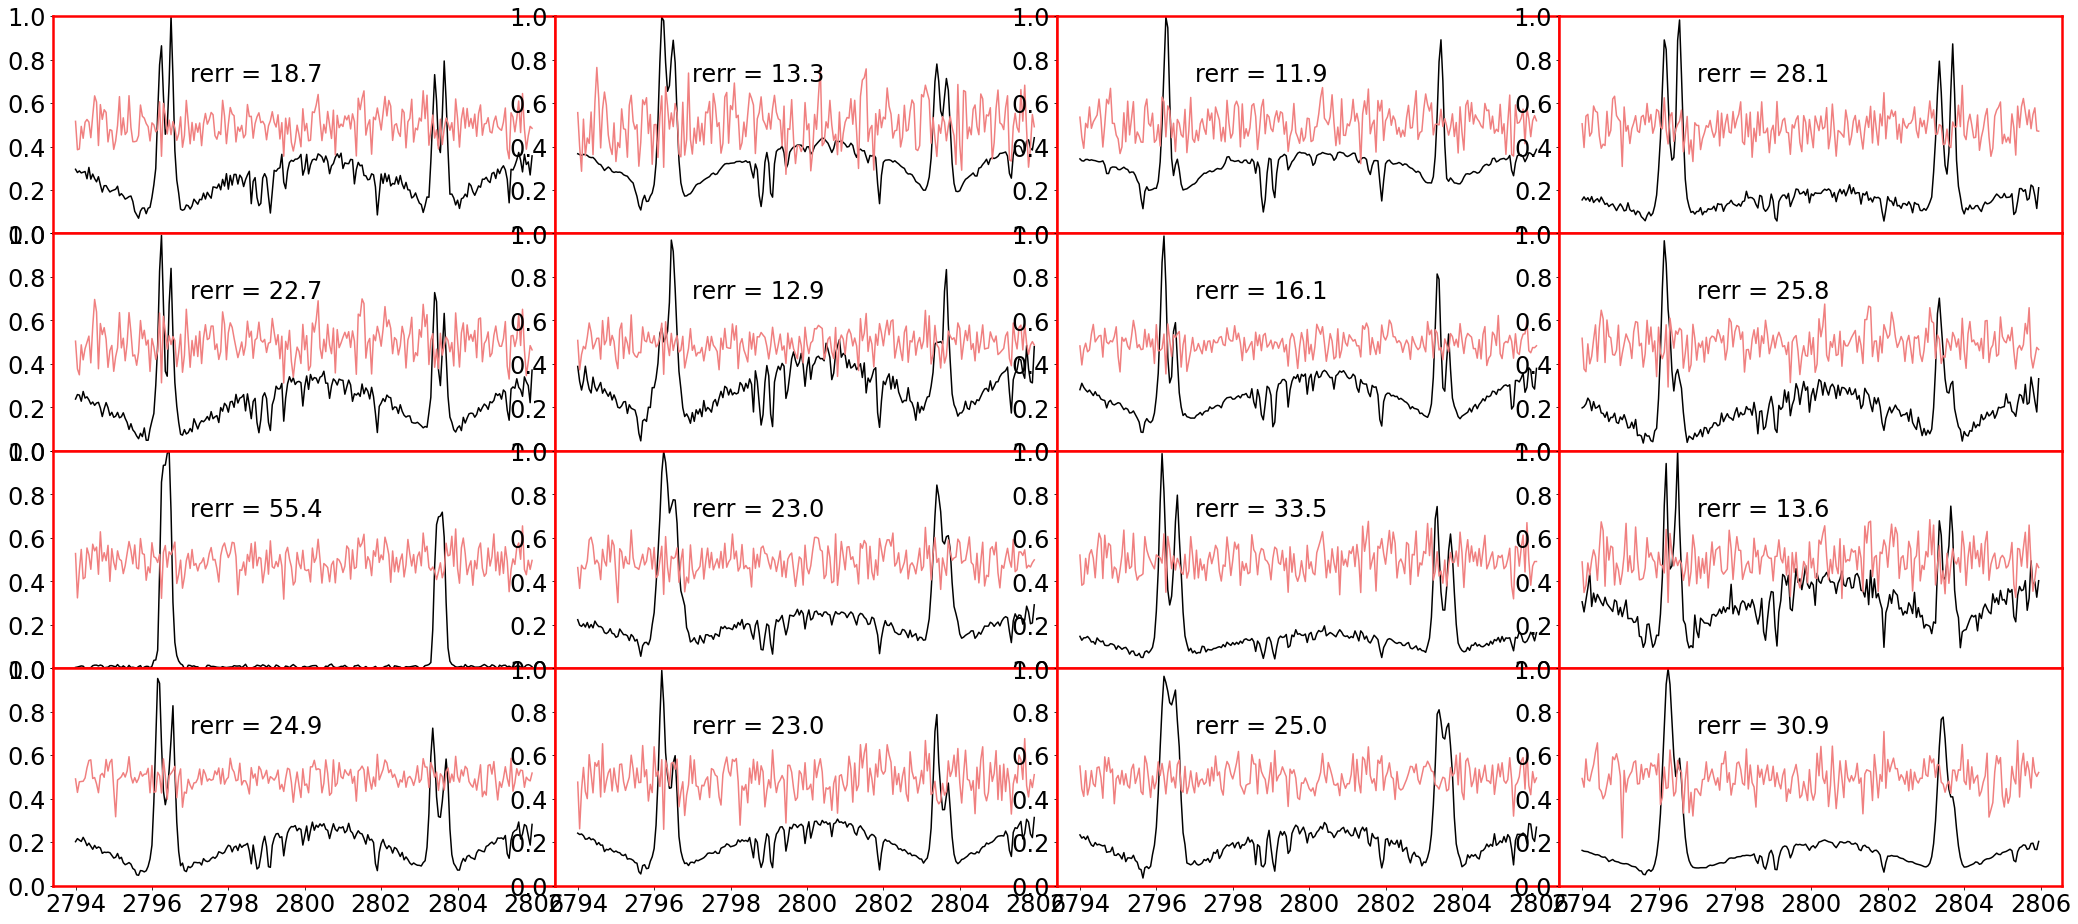

15

In [9]:
spectra_compare(model, X_vae_test, MgIIk) # look at untrained model output, does your model feed through information correctly?

Training loop 

<Figure size 432x288 with 0 Axes>

[0.70548964]


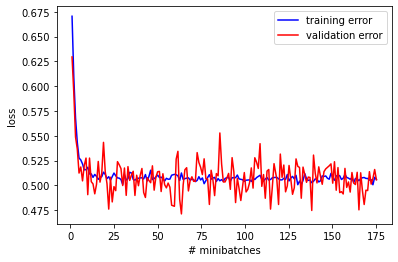

<Figure size 2592x1152 with 0 Axes>

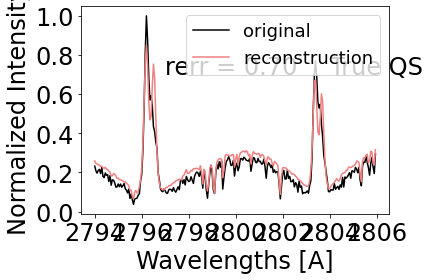

100%|██████████| 3/3 [03:58<00:00, 79.52s/it]

Epoch 2, Train Loss: 0.5066


In [10]:
# Cell to train your data and monitor the training progress.
# try:
#     None - 1 # this is just to omit the cell in the jupyterbook, it has nothing to do with the training loop.
    
# Make empty lists to track the losses on validation and training
losses = []
valid_losses = []

plx = []
ply_train = []
ply_val = []
train_loss_list = []


# set to train mode so that dropout or batchnorm behave accordingly
model.train()
ind = np.random.randint(0, X_vae_test.shape[0], 1) # get a random index to track the training progress of one single spectrum.
torch.cuda.empty_cache() # empty the GPU data cache.
model.to(device, dtype=torch.float) # send model to device (GPU here)

factor = 10 # prefactor to play with the kl-divergence

for e in tqdm(range(N_EPOCHS)):

    train_loss = 0
    running_loss = 0.0
    running_lossv = 0.0

    for i, x in enumerate((traindata)):

        x = x.view(-1, 1, input_dim) # -1 adapts to the batch size
        x = x.to(device, dtype= torch.float)


        # update the gradients to zero
        optimizer.zero_grad()
        # forward pass
        model.train()

        reconstructed_x, z_mu, z_var = model(x)

        # reconstruction loss

        reconstructed_x = reconstructed_x.unsqueeze(1)
        if reconstructed_x.shape != x.shape:
            raise Exception('not same shape!', x.shape, reconstructed_x.shape)
        recon_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
        # kl divergence loss
        kl_loss = factor*0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        loss = recon_loss + kl_loss

        running_loss += loss.item()/batch_size_train/MgIIk['n_breaks']
        losses.append(loss.item()/batch_size_train/MgIIk['n_breaks'])
        # backward pass
        loss.backward()
        train_loss += loss.item()/batch_size_train/MgIIk['n_breaks']
        # update the weights
        optimizer.step()

        if i % 10 == 9: 

            #VALIDATION
            with torch.no_grad():
                model.eval()
                running_lossv = 0
                torch.cuda.empty_cache()

                local_test = next(iter(validdata))

                v = local_test.view(-1, 1, input_dim) # -1 adapts to the batch size
                v = v.to(device, dtype= torch.float)

                # forward pass
                reconstructed_v, z_muv, z_varv = model(v)

                # reconstruction loss
                reconstructed_v = reconstructed_v.unsqueeze(1)
                if reconstructed_v.shape != v.shape:
                    raise Exception('not same shape!', v.shape, reconstructed_v.shape)
                recon_lossv = F.binary_cross_entropy(reconstructed_v, v, reduction='sum')
                # kl divergence loss
                kl_lossv = factor*0.5 * torch.sum(torch.exp(z_varv) + z_muv**2 - 1.0 - z_varv)
                # total loss
                valid_loss = recon_lossv + kl_lossv
                valid_losses.append(valid_loss.item()/batch_size_val/MgIIk['n_breaks'])#/len(validdata))
                running_lossv += valid_loss.item()/batch_size_val/MgIIk['n_breaks']#/len(validdata)

            # plot the training and validation loss in a dynamic manner plus the randomly picked spectrum to reconstruct.
            display.clear_output(wait=True)
            display.display(plt.gcf())

            plx.append(e*len(traindata)/10+(i+1)/10)
            ply_train.append(running_loss/10)
            ply_val.append(running_lossv)

            plt.plot(plx, ply_train, '-b', label='training error')
            plt.plot(plx, ply_val, '-r', label='validation error')
            plt.xlabel('# minibatches')
            plt.ylabel('loss')
            plt.legend()
#             model.train()
            plot_single_spectrum(model, X_vae_test, ind, MgIIk)

            plt.show()
            time_system.sleep(.2)

            running_loss = 0.0
            running_lossv = 0.0



    train_loss /= len(traindata)
    train_loss_list.append( train_loss )
    print(f'Epoch {e}, Train Loss: {train_loss:.4f}')
        
# except Exception:
#     pass



In [11]:
# torch.save(model.state_dict(), 'vae_smlbook_model.pt')
# model.load_state_dict(torch.load('vae_smlbook_model.pt'))

Now check the training progress on a random sample of spectra: 

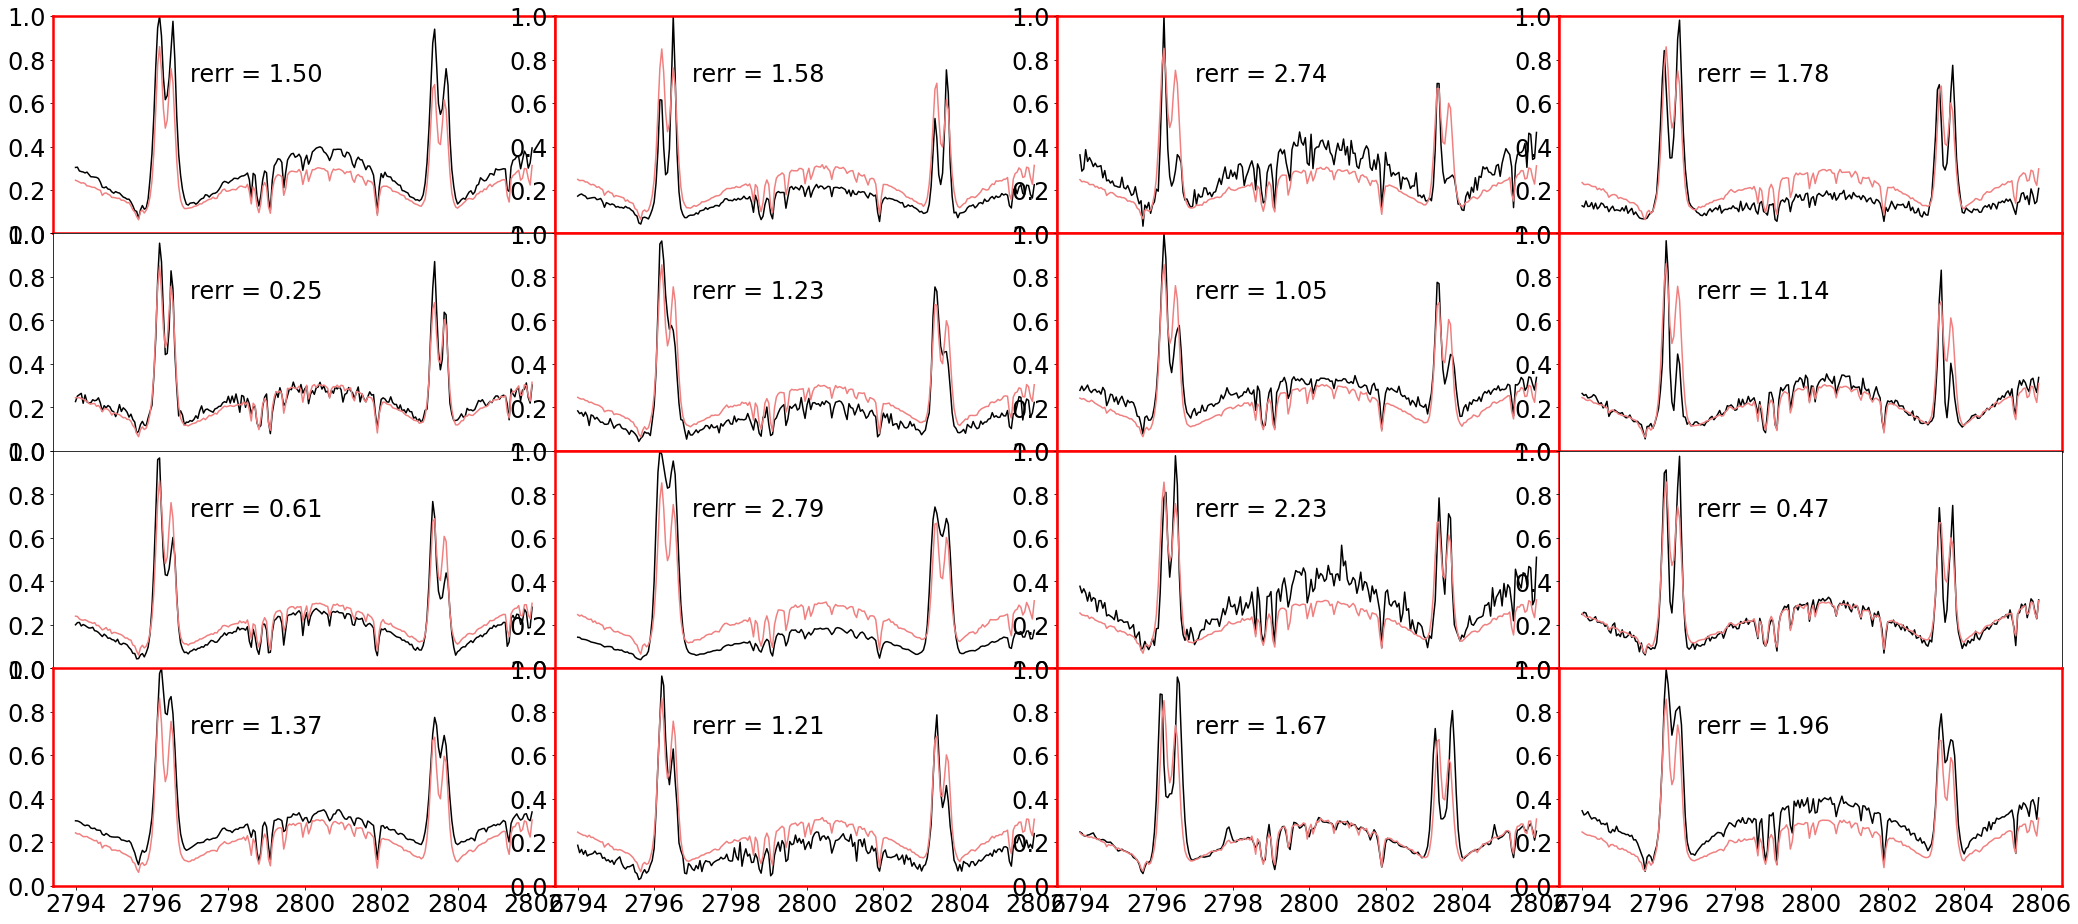

15

In [13]:
spectra_compare(model, X_vae_test, MgIIk)

In [14]:
model.eval() # switch the model to evaluate mode. Then it will ignore dropouts and the gradient. 
model.cpu()

torch.cuda.empty_cache()
with torch.no_grad(): # you can also use no_grad to ignore the gradient on the forward pass
    T_vae_test = torch.tensor(X_vae_test)
    v = T_vae_test.view(-1, 1, n_breaks) # -1 adapts to the batch size
    v = v.to('cpu', dtype= torch.float) # sent the tensor to be tested to the device you want to use. 

    # forward pass
    reconstructed_v, z_muv, z_varv = model(v)
recon_spectra = reconstructed_v.detach().numpy()
# reconstruction loss
reconstructed_v = reconstructed_v.unsqueeze(1)
if reconstructed_v.shape != v.shape:
    raise Exception('not same shape!', v.shape, reconstructed_v.shape)
recon_loss_mean = np.mean((np.square(X_vae_test - recon_spectra)).sum(axis=1)) # compute the average reconstruction loss over the entire dataset.
recon_loss_max = np.max((np.square(X_vae_test - recon_spectra)).sum(axis=1)) # compute the maximum reconstruction loss over the entire dataset.
print('overall validation error mean : ', recon_loss_mean)
print('overall validation error max : ', recon_loss_max)

overall validation error mean :  1.5194564423069334
overall validation error max :  16.423408359741536


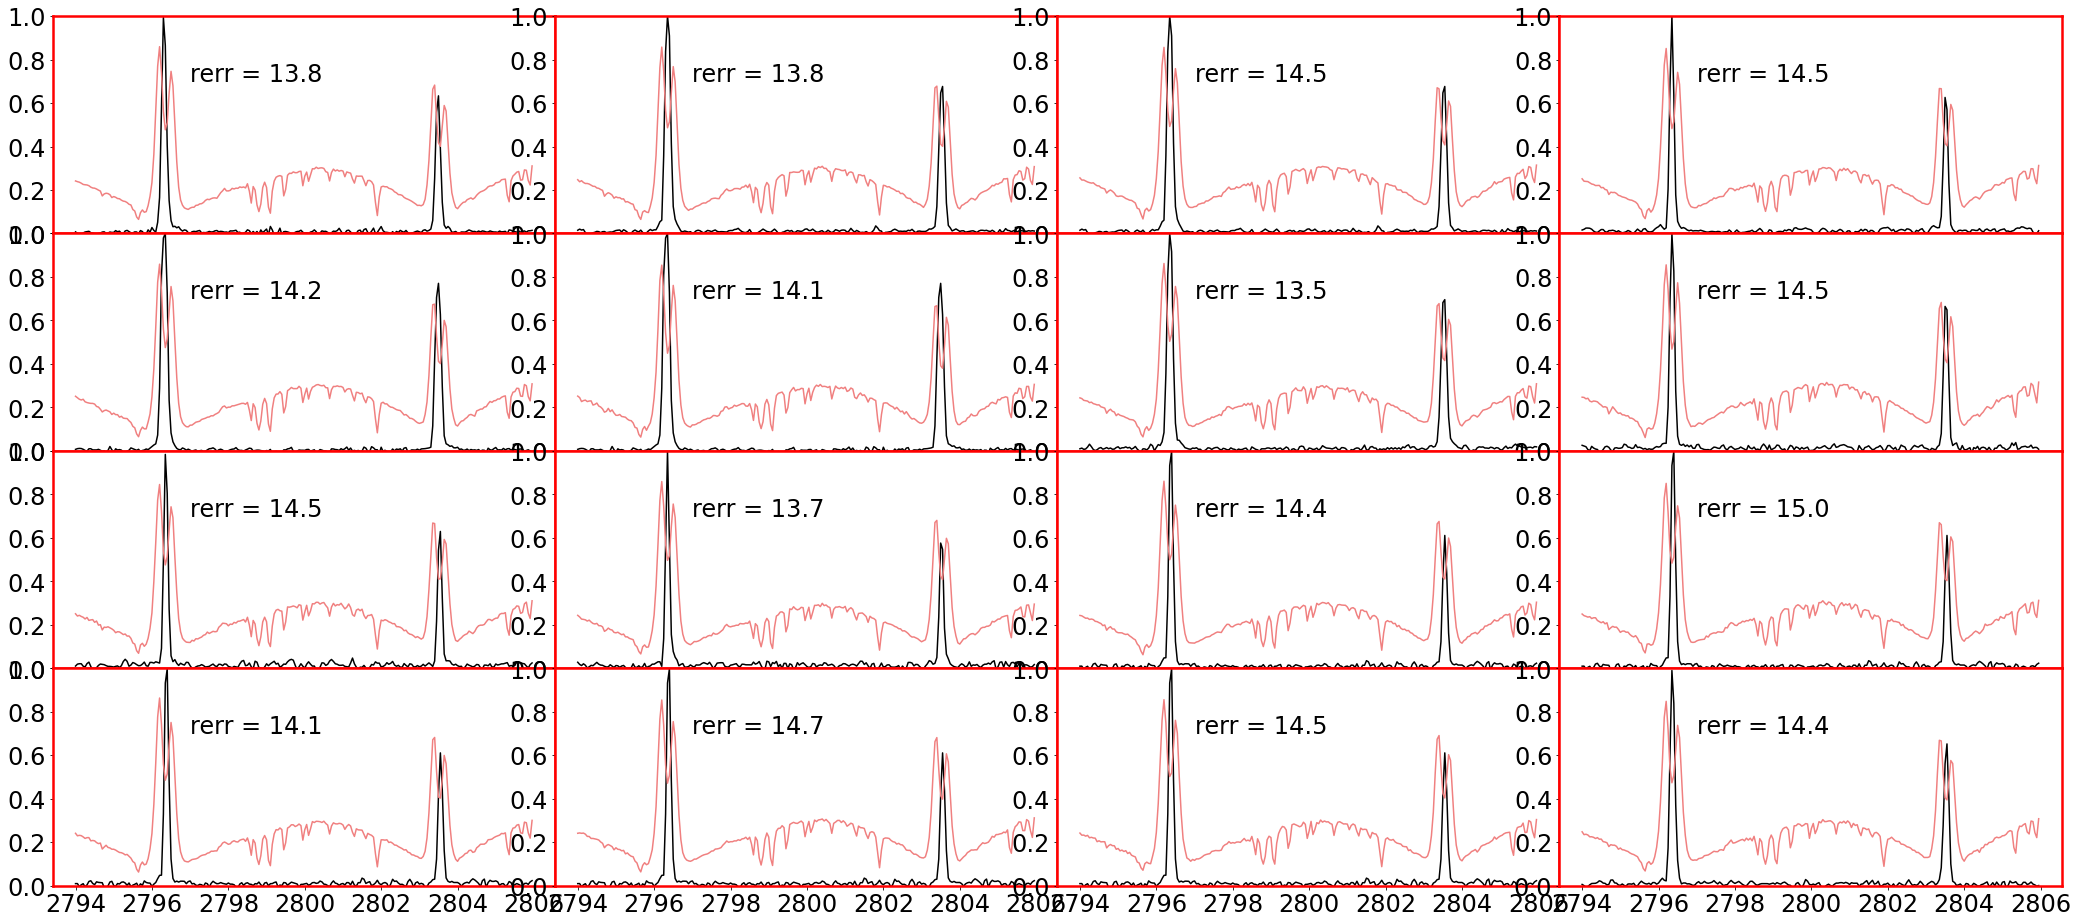

15

In [15]:
test_errors_inds = np.argsort((np.square(X_vae_test - recon_spectra)).sum(axis=1)) # Collect the spectra with the highest reconstruction error. 
spectra_compare(model, X_vae_test[test_errors_inds][-16:-1], MgIIk) # Look at the spectra with the highest reconstruction error.